In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/Datasets/Raw_Data.xlsx')
df.head()

,Customer,Check-In Questionnaire: What persuaded you to choose our hotel for your stay?,Check-Out Questionnaire: What impressed you the most during your stay?
0,Customer1,Delicious Breakfast; Fast and Reliable Wi-Fi; ...,Fast and Reliable Wi-Fi; Delicious Breakfast
1,Customer2,Quiet and Restful Environment; Fast and Reliab...,Quiet and Restful Environment; Fast and Reliab...
2,Customer3,Reservation & Communication; Fast and Reliable...,Fast and Reliable Wi-Fi; Reservation & Communi...
3,Customer4,Stylish Interior Design; Quiet and Restful Env...,Quiet and Restful Environment; Friendly and He...
4,Customer5,Stylish Interior Design; Quiet and Restful Env...,Reservation & Communication


## data cleaning( removing the semicolon for each entry and splitting it into individual responses for each customer)

In [4]:
df = df.rename(columns={
    'Check-In Questionnaire: What persuaded you to choose our hotel for your stay?': 'check_in',
    'Check-Out Questionnaire: What impressed you the most during your stay?': 'check_out'
})
df['check_in'] = df['check_in'].fillna('')
df['check_out'] = df['check_out'].fillna('')

df['check_in_split'] = df['check_in'].str.split(';').apply(lambda x: [i.strip() for i in x if i.strip()])
df['check_out_split'] = df['check_out'].str.split(';').apply(lambda x: [i.strip() for i in x if i.strip()])

checkin = df[['Customer', 'check_in_split']].explode('check_in_split').rename(columns={'check_in_split': 'check_in'})
checkout = df[['Customer', 'check_out_split']].explode('check_out_split').rename(columns={'check_out_split': 'check_out'})

final = pd.merge(checkin, checkout, on='Customer', how='outer').reset_index(drop=True)



In [5]:
final.head()

,Customer,check_in,check_out
0,Customer1,Delicious Breakfast,Fast and Reliable Wi-Fi
1,Customer1,Delicious Breakfast,Delicious Breakfast
2,Customer1,Fast and Reliable Wi-Fi,Fast and Reliable Wi-Fi
3,Customer1,Fast and Reliable Wi-Fi,Delicious Breakfast
4,Customer1,Family-Friendly Services,Fast and Reliable Wi-Fi


In [6]:
final['check_in'].value_counts()

,count
check_in,
Quiet and Restful Environment,109
Fast and Reliable Wi-Fi,88
Delicious Breakfast,76
Comfortable and Clean Rooms,75
Modern Fitness Facilities,72
Business Amenities,49
Friendly and Helpful Staff,49
Family-Friendly Services,38
Easy Parking & Check-in,36


In [7]:
final['check_out'].value_counts()

,count
check_out,
Quiet and Restful Environment,174
Fast and Reliable Wi-Fi,117
Delicious Breakfast,83
Comfortable and Clean Rooms,55
Modern Fitness Facilities,48
Friendly and Helpful Staff,42
Business Amenities,38
Reservation & Communication,37
Family-Friendly Services,16


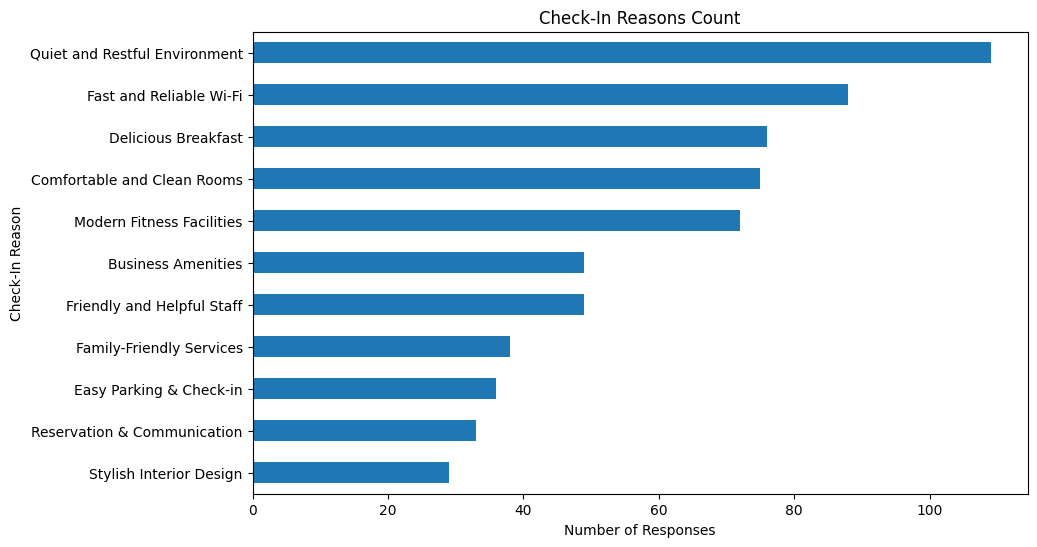

In [8]:
import matplotlib.pyplot as plt

checkin_count = final['check_in'].value_counts()
checkin_count.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of Responses')
plt.ylabel('Check-In Reason')
plt.title('Check-In Reasons Count')
plt.gca().invert_yaxis()
plt.show()


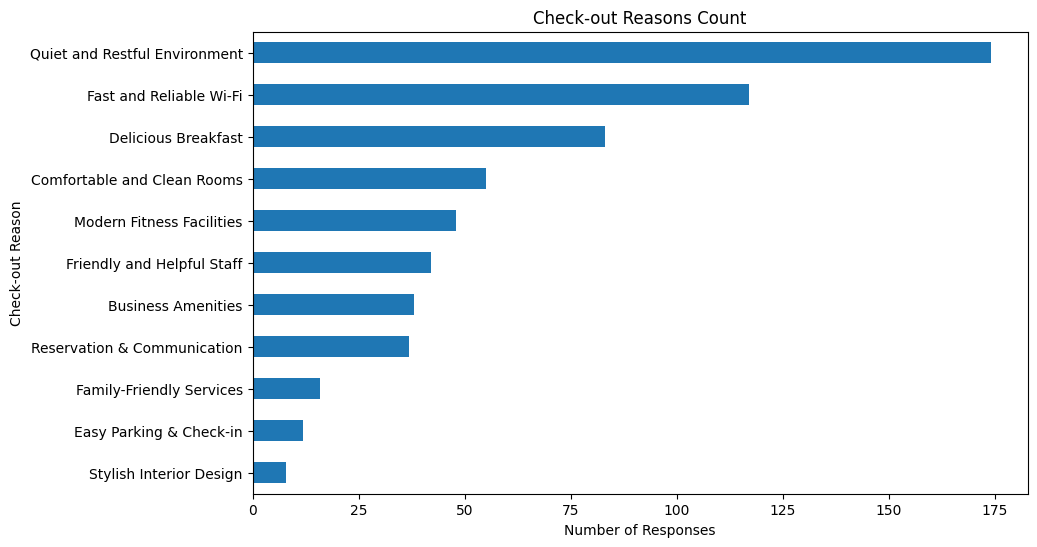

In [9]:
import matplotlib.pyplot as plt

checkout_count = final['check_out'].value_counts()
checkout_count.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of Responses')
plt.ylabel('Check-out Reason')
plt.title('Check-out Reasons Count')
plt.gca().invert_yaxis()
plt.show()

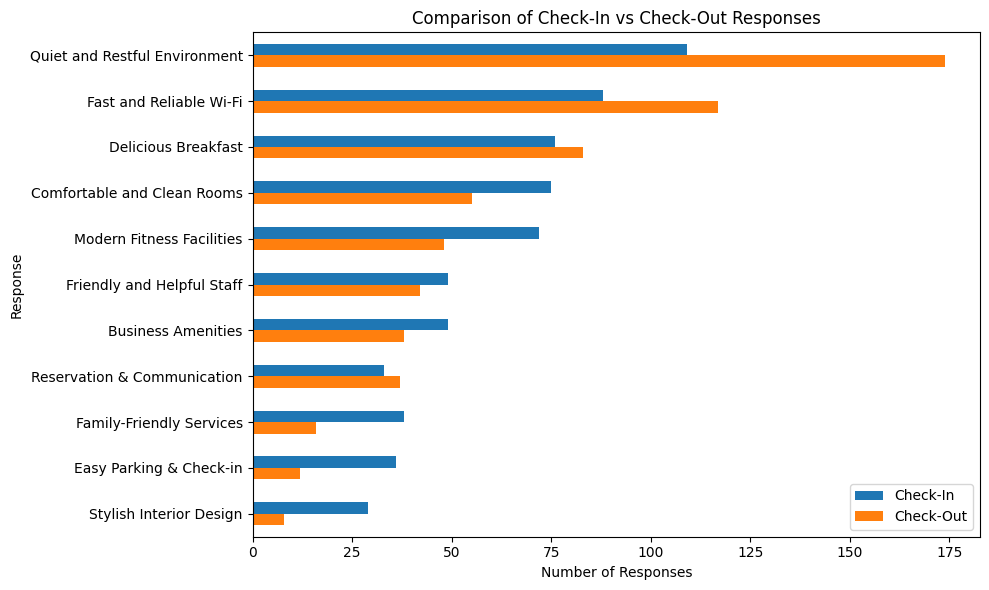

In [9]:
combined = pd.concat([checkin_count, checkout_count], axis=1, keys=['Check-In', 'Check-Out']).fillna(0)

top_n = combined.sum(axis=1).sort_values(ascending=False)
combined_top = combined.loc[top_n.index]

combined_top.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of Responses')
plt.ylabel('Response')
plt.title('Comparison of Check-In vs Check-Out Responses')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()


## Combining check-in and check-out counts to compare

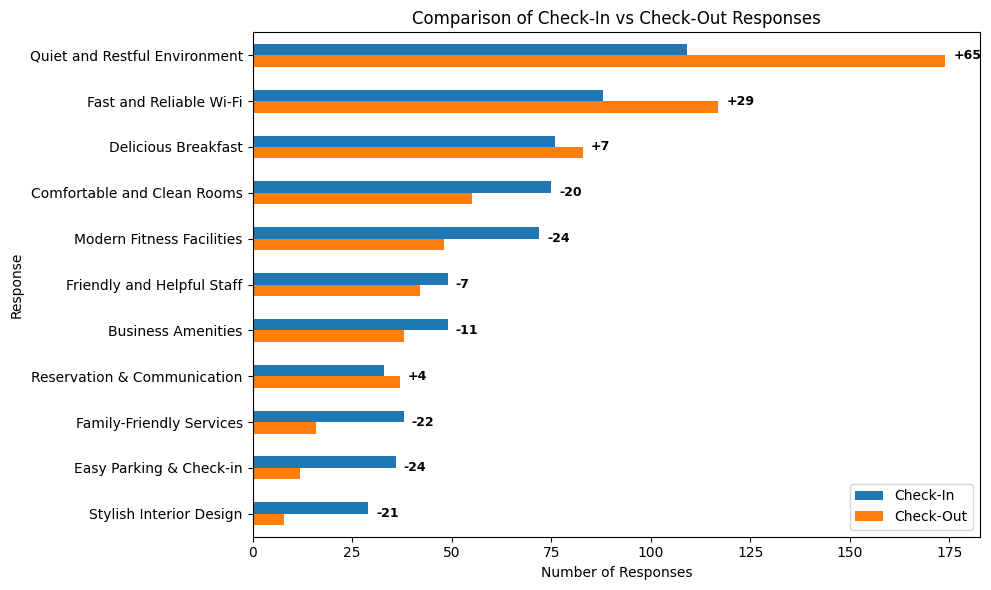

In [10]:
combined = pd.concat([checkin_count, checkout_count], axis=1, keys=['Check-In', 'Check-Out']).fillna(0)
top_n = combined.sum(axis=1).sort_values(ascending=False)
combined_top = combined.loc[top_n.index]

ax = combined_top.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of Responses')
plt.ylabel('Response')
plt.title('Comparison of Check-In vs Check-Out Responses')
plt.gca().invert_yaxis()
plt.legend()

for i, (index, row) in enumerate(combined_top.iterrows()):
    checkin_val = row['Check-In']
    checkout_val = row['Check-Out']
    diff = checkout_val - checkin_val
    x_pos = max(checkin_val, checkout_val) + 2
    ax.text(x_pos, i, f"{diff:+.0f}", va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


In [10]:
final.head()

,Customer,check_in,check_out
0,Customer1,Delicious Breakfast,Fast and Reliable Wi-Fi
1,Customer1,Delicious Breakfast,Delicious Breakfast
2,Customer1,Fast and Reliable Wi-Fi,Fast and Reliable Wi-Fi
3,Customer1,Fast and Reliable Wi-Fi,Delicious Breakfast
4,Customer1,Family-Friendly Services,Fast and Reliable Wi-Fi


 ## categorising the different responses to see which are star, over, under and low impact performers by using median of check-in and check-out

In [11]:

checkin_counts = final["check_in"].value_counts().rename_axis("Response").reset_index(name="Check-In")
checkout_counts = final["check_out"].value_counts().rename_axis("Response").reset_index(name="Check-Out")

summary = pd.merge(checkin_counts, checkout_counts, on="Response", how="outer").fillna(0)

summary["Difference"] = summary["Check-Out"] - summary["Check-In"]
summary["% Change"] = ((summary["Difference"]) / summary["Check-In"].replace(0, 1)) * 100

category_map = {
    "Delicious Breakfast": "Amenities",
    "Fast and Reliable Wi-Fi": "Amenities",
    "Family-Friendly Services": "Service",
    "Comfortable and Clean Rooms": "Ambience",
    "Friendly and Helpful Staff": "Service",
    "Business Amenities": "Amenities",
    "Reservation & Communication": "Service",
    "Modern Fitness Facilities": "Amenities",
    "Easy Parking & Check-in": "Logistics",
    "Stylish Interior Design": "Ambience",
    "Quiet and Restful Environment": "Ambience"
}
summary["Category"] = summary["Response"].map(category_map).fillna("Other")

def classify_performance(row, median_checkin, median_checkout):
    if row["Check-In"] >= median_checkin and row["Check-Out"] >= median_checkout:
        if row["Difference"] >= 0:
            return "Star Performer"
        else:
            return "Underperformer"
    elif row["Check-In"] < median_checkin and row["Check-Out"] >= median_checkout:
        return "Overperformer"
    elif row["Check-In"] >= median_checkin and row["Check-Out"] < median_checkout:
        return "Underperformer"
    else:
        return "Low Impact"

med_in = summary["Check-In"].median()
med_out = summary["Check-Out"].median()
summary["Performance Class"] = summary.apply(lambda row: classify_performance(row, med_in, med_out), axis=1)
summary = summary.sort_values("Check-Out", ascending=False).reset_index(drop=True)
summary


,Response,Check-In,Check-Out,Difference,% Change,Category,Performance Class
0,Quiet and Restful Environment,109,174,65,59.633028,Ambience,Star Performer
1,Fast and Reliable Wi-Fi,88,117,29,32.954545,Amenities,Star Performer
2,Delicious Breakfast,76,83,7,9.210526,Amenities,Star Performer
3,Comfortable and Clean Rooms,75,55,-20,-26.666667,Ambience,Underperformer
4,Modern Fitness Facilities,72,48,-24,-33.333333,Amenities,Underperformer
5,Friendly and Helpful Staff,49,42,-7,-14.285714,Service,Underperformer
6,Business Amenities,49,38,-11,-22.448980,Amenities,Underperformer
7,Reservation & Communication,33,37,4,12.121212,Service,Low Impact
8,Family-Friendly Services,38,16,-22,-57.894737,Service,Low Impact
9,Easy Parking & Check-in,36,12,-24,-66.666667,Logistics,Low Impact
